In [31]:
import numpy as np
from stl import mesh
import nrrd
import matplotlib.pyplot as plt

In [62]:
# Load the cortex 3D model (area 315L.stl)
cortexMesh = mesh.Mesh.from_file('315L.stl')

# Do triangles land inside the annotation atlas
We're going to load the 10um annotation dataset and just plot some vertices on top of slices to make sure we have everything lined up properly

In [18]:
# Load the 10um annotation file (annotation_10.nrrd)
ann10, meta = nrrd.read('annotation_10.nrrd')

In [63]:
# Convert vertices to ccf coordinate range
# +x = AP*, +y = ML*, +z = DV*
triangles = cortexMesh.vectors
trianglesCCF = np.empty(triangles.shape)

In [64]:
# *1000 to um, /10 to ccf indexes, then round
flipVector = [1,-1,1]
for i, triangle in enumerate(triangles):
    for j, vertex in enumerate(triangle):
        trianglesCCF[i][j] = np.round(np.multiply(vertex,flipVector)*1000/10)

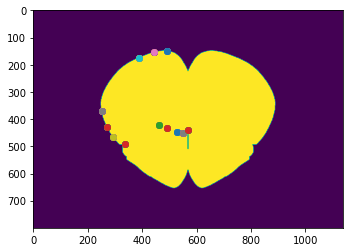

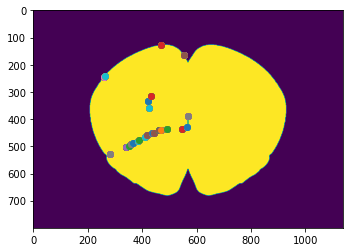

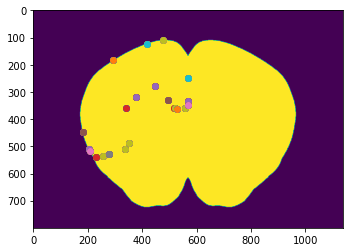

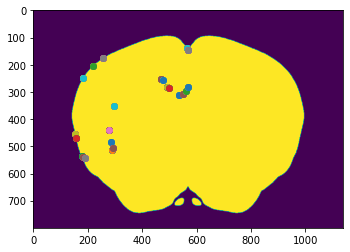

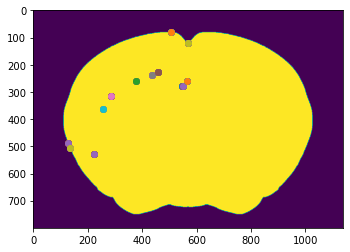

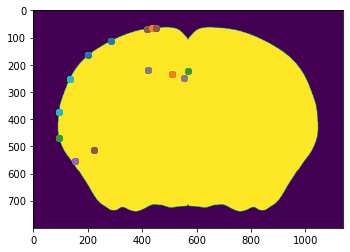

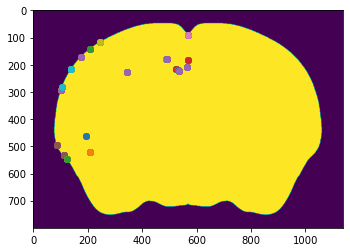

In [71]:
# Check that in fact we have vertices in the right places, looks like we do
for apIDX in [300,350,400,450,500,550,600]:
    plt.figure()
    plt.imshow(ann10[apIDX,:,:]>0)
    for i, triangle in enumerate(trianglesCCF):
        for j, vertex in enumerate(triangle):
            if vertex[0]==apIDX:
                plt.scatter(vertex[1],vertex[2])

# Check if triangles are entirely on the surface mask
Load the boundary and find all triangles that are entirely defined on the surface mask

In [77]:
# Load the 10um mask (isocortex_boundary_10.nrrd)
boundary10, meta = nrrd.read('isocortex_boundary_10.nrrd')
# Unique values are 0, 1, 3, 4, where #1 is the outer surface

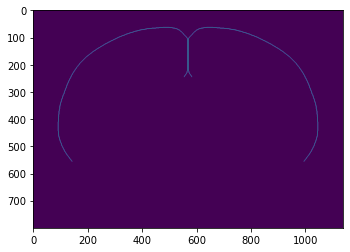

In [83]:
plt.imshow(boundary10[550,:,:]==1)

In [88]:
# Now go through and find all vertices that are inside the outer surface and only keep triangles where all *three* vertices are on the surface
surfaceIdx = []
for i, triangle in enumerate(trianglesCCF):
    for j, vertex in enumerate(triangle):
        if not boundary10[int(vertex[0]),int(vertex[1]),int(vertex[2])]==1:
            break
        surfaceIdx.append(i)

# Remove all triangles outside the surface

In [91]:
surfaceTriangles = triangles[surfaceIdx]

# Save to a new file, then look at this in blender

In [100]:
surfaceMesh = mesh.Mesh(data = numpy.zeros(surfaceTriangles.shape[0], dtype=mesh.Mesh.dtype))
surfaceMesh.vectors = surfaceTriangles

In [101]:
surfaceMesh.save('315L_surface.stl')

# Attempt #2: Check if triangles are within 20 um of the surface mask
Load the boundary and find all triangles that have vertices within some distance of the surface mask. The point here is maybe the reason we lose most of the triangles is because of rounding error generating the 3D model and smoothing it, so maybe we can recover those triangles here?

In [105]:
surfaceIdx = []
for i, triangle in enumerate(trianglesCCF):
    for j, vertex in enumerate(triangle):
        # check in the surrounding region +/- 2 in all directions to see if there is a surface voxel
        vint = [int(vertex[0]),int(vertex[1]),int(vertex[2])]
        done = False
        for xi in np.arange(-2,3):
            for yi in np.arange(-2,3):
                for zi in np.arange(-2,3):
                    if boundary10[vint[0]+xi, vint[1]+yi, vint[2]+zi]==1:
                        done = True
                        surfaceIdx.append(i)
                    if done:
                        break
                if done:
                    break
            if done:
                break

AttributeError: 'list' object has no attribute 'shape'

In [108]:
surfaceTriangles = triangles[surfaceIdx]

In [109]:
surfaceMesh = mesh.Mesh(data = numpy.zeros(surfaceTriangles.shape[0], dtype=mesh.Mesh.dtype))
surfaceMesh.vectors = surfaceTriangles
surfaceMesh.save('315L_surface_within20.stl')

In [ ]:

# Save to a new file (then, load in Blender, compute UV mask from surface, export)

In [ ]:
# Load the UV file for the cortex surface

# Convert to a flatmap, based on how dorsal_flatmap.npy runs, using the new streamlines from Cyrille and/or the streamlines from Allen